In [1]:
import os
import time
import cv2
import pickle
import numpy as np
import torch
import torch.nn as nn
import easyocr
import matplotlib.pyplot as plt

reader = easyocr.Reader(['en'],model_storage_directory = r'/home/anaconda3/envs/ning/lib/python3.8/site-packages/easyocr/easyOCR_model',download_enabled=False) # need to run only once to load model into memory


def show_time(func):
    def wrapped(*args,**kwargs):       
        start_time = time.time()
        result = func(*args,**kwargs)
        end_time = time.time()
        
        print("Costs %d seconds\n"%(end_time-start_time))
        
        return result
    return wrapped

class Video(object):
    
    def __init__(self,video_path = None):
        self.video_path = video_path
        self.capture = cv2.VideoCapture(video_path)
        
        self.width = int(self.capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        
        self.height = int(self.capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.shape = (self.width, self.height)
        self.fps = self.capture.get(cv2.CAP_PROP_FPS)
        self.total_frame = self.capture.get(cv2.CAP_PROP_FRAME_COUNT)
        self.duration = int(self.total_frame//self.fps)
        
        
        sec = self.duration % 60
        minu = (self.duration//60)%60
        hr = self.duration // 3600
        self.duration_hms = (hr,minu,sec)
    
    def __len__(self):
        return int(self.total_frame)
    def __repr__(self):
        self.info = 'video path: {0}\nimage size: {1}\nfps:{2}\nframe num: {3}\
            \nduration(s): {4}s {5}\n'.format(self.video_path,\
                    (self.width,self.height),self.fps,self.total_frame,\
                        self.duration,self.duration_hms)
        return self.info

    
    def play(self,start_frame=0,end_frame=None):
        self.capture.set(cv2.CAP_PROP_POS_FRAMES,start_frame)
        
        while(self.capture.isOpened()):
            ret, frame = self.capture.read()
            cv2.imshow('frame',frame)
            
            current_frame_pos = self.capture.get(cv2.CAP_PROP_POS_FRAMES)

            if (cv2.waitKey(1) & 0xFF == ord('q')) or \
                end_frame is not None and current_frame_pos>end_frame:
                break

                
        self.capture.release()
        cv2.destroyAllWindows()
    
    
    def _clip(self,save_path,start_frame=0,end_frame=None,\
              videoWriter=None,new_frame_size = None) -> bool:
        
        # 设置参数
        if end_frame is None or end_frame > self.total_frame:
            end_frame = self.total_frame
            
        assert start_frame < end_frame <= self.total_frame , "起止帧大小不对"
        if videoWriter is None:
            video_fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', '2')
            videoWriter = cv2.VideoWriter(save_path,video_fourcc,\
                                          self.fps,(self.width,self.height))
        
        # 提示视频时长
        print('start:%d\nend:%d\nduration:%ds\n'%(start_frame,end_frame,(end_frame-start_frame)/self.fps))
        
        
        # 开始写视频
        self.capture.set(cv2.CAP_PROP_POS_FRAMES,start_frame)
        while(self.capture.isOpened()):
            current_frame_pos = self.capture.get(cv2.CAP_PROP_POS_FRAMES)

            if current_frame_pos<end_frame:
                ret, frame = self.capture.read()
                
                # 改变frame大小
                if new_frame_size is not None:
                    frame = cv2.resize(frame, new_frame_size,interpolation=cv2.INTER_CUBIC)

                if ret:
                    videoWriter.write(frame)
                else:
                    print('视频解析错误')
                    return False
            else:
                return True
        return False
    
    @show_time
    def clip_by_time(self,save_path,start_time=0,duration=None,end_time=None,\
                     video_writer:cv2.VideoWriter=None,new_frame_size:tuple=None) -> bool:
        '''
        :param save_path: 保存视频路径
        :param start_time: 截取视频开始时间
        :param end_time: 截取视频结束时间
        :param video_writer: <cv2.VideoWriter> 
        :param new_frame_size: 新视频大小

        :return: <bool> 是否成功截取视频
        
        '''
        start_time = self.time2sec(start_time)
        
        if duration is not None:
            duration = self.time2sec(duration)
            end_time = start_time + duration
        else:
            end_time = self.time2sec(end_time)
            
        start_frame = self.time2frame_idx(start_time)
        end_frame = self.time2frame_idx(end_time)
        
        # print("expected time:%ds"%(0.324*duration + 2))
        return self._clip(save_path,start_frame,end_frame,video_writer,new_frame_size)
        
    def get_frame(self,frame_idx):
        if frame_idx > self.total_frame:
            print('frame_idx is greater than total frame')
            return None
        self.capture.set(cv2.CAP_PROP_POS_FRAMES,frame_idx)
        if self.capture.isOpened():
            ret, frame = self.capture.read()
            if ret:
                return frame
        return None
        
    
    def get_frame_by_time(self,time):
        
        return self.get_frame(self.time2frame_idx(time))
    
    @show_time
    def sample_class(self,root_path,time_seg:list,fps,class_name,down_sampling = 1):
        
        # 判断有无文件夹,没有则创建文件夹
        class_path = os.path.join(root_path,class_name)
        if not os.path.exists(class_path):
            os.makedirs(class_path)
            print('Created dir:%s'%class_path)
        
        
        i = 0
        pic_num = len(os.listdir(class_path))
        for start_time,end_time in time_seg:
            start_frame = self.time2frame_idx(start_time)
            end_frame = self.time2frame_idx(end_time)

            for frame_idx in range(start_frame,end_frame,int(fps)):
                idx = i + pic_num
                frame_path = os.path.join(class_path,'%s_.%d.png'%(class_name,idx))
                cv2.imwrite(frame_path,self.get_frame(frame_idx)[::down_sampling,::down_sampling])
                i += 1
        else:
            print('Successfully write all %d images\n%d images in class \'%s\''%(i,idx+1,class_name))
            return True
        
        print('Not all expected pictures are written')
        return False
        
    @staticmethod
    def time2hms(time_by_sec):
        if type(time_by_sec) is tuple:
            return time_by_sec
        sec = time_by_sec % 60
        minu = (time_by_sec//60)%60
        hr = time_by_sec // 3600
        return hr,minu,sec
    
    @staticmethod
    def time2sec(hms):
        if type(hms) is not tuple:
            return hms
        return hms[0]*3600 + hms[1]*60 + hms[2]
    
    def frame_idx2time(self,frame_idx,natural = False,to_hms = False):
        
        time = frame_idx/self.fps
        if not to_hms:
            return time.astype(np.int) if natural else time
                
        hr,minu,sec = self.time2hms(time)
        if natural:
            return int(hr),int(minu),int(sec)
        
        return hr,minu,sec

    def time2frame_idx(self,time:float or tuple):
        '''
        时间转换为帧，时间类型可以是float/int/tuple
        '''
        
        
        time = self.time2sec(time)
        frame_idx = int(time * self.fps)
        return frame_idx



    def show_video_info(self):
        print(self)
    



class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding = 1),
            nn.ReLU(),
            
            nn.MaxPool2d(2)  #outputsize = (16,45,80)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,64,kernel_size=3,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2) #outputsize = (32,22,40)
        )
        self.dense1 = nn.Sequential(
            nn.Linear(64*22*40,32),
            nn.ReLU()
        )
        self.dense2 = nn.Sequential(
            nn.Linear(32,1)
        )
        
        
    def forward(self,x):
        # x = transform(x,2)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        x = self.dense1(x)
        out = self.dense2(x)
        return out


class TennisGame_processor(Video):
    
    def __init__(self,video_path = None,identifier_model_path = None,cls_file=None):
        super(TennisGame_processor,self).__init__(video_path)
        self.model = torch.load(identifier_model_path,map_location=torch.device('cpu'))
        self.cls_file = cls_file
        
    
    def transform(self,image):
        image = image[::2,::2]
        blur = cv2.GaussianBlur(cv2.cvtColor(np.asarray(image),cv2.COLOR_BGR2GRAY),(5,5),0)[::2,::2]
        blur = cv2.GaussianBlur(blur,(3,3),0)[::2,::2]/128
        return blur[np.newaxis,np.newaxis,...].astype(np.float64)
        # return torch.tensor(blur[np.newaxis,...].astype(np.float64), dtype=torch.float32)

    
    
    def get_frames(self,start_frame,f,frame_num,transform = lambda x:x):

        frames = self.transform(self.get_frame(start_frame))
        cur_frame = start_frame
        i = 1
        while i<frame_num:
                        
            cur_frame += f
            if cur_frame >= self.total_frame:
                break
            frames = np.concatenate((frames,self.transform(self.get_frame(cur_frame))))
            i += 1
        return frames

        
    @show_time
    def identify(self,start_time=0,end_time= None,f = 25,batch_size=60,save_path = None) -> np.ndarray:
        print('identifying ...\n')
        start_frame = int(self.time2frame_idx(start_time))
        end_frame = int(self.time2frame_idx(end_time)) if end_time is not None else int(self.total_frame)
        clss = []
        frame_idxs = []
        frame_idx = start_frame
        while frame_idx< end_frame:
            try:
                frames = self.get_frames(frame_idx,f,batch_size)
            except:
                print('cur_frame_idx%d,end_frame%d'%(frame_idx,end_frame))
                frame_idx += f*batch_size
                continue
            if frames is None:
                break
            frame_tensor = torch.tensor(frames,dtype = torch.float32)
            predict = torch.nn.Sigmoid()(self.model(frame_tensor).squeeze())
            
            
            clss.extend((np.round(predict.detach().numpy()).astype(np.int)))
            frame_idxs.extend(list(range(frame_idx,frame_idx+f*len(predict),f)))
            
            assert len(frame_idxs) == len(clss), 'len(frame_idxs) != len(clss)!\n'
            frame_idx += f*batch_size
        
        
        # np.save()
        frame_idxs = np.array(frame_idxs)
        times = self.frame_idx2time(np.array(frame_idxs),True)[np.newaxis,...]
        result = np.concatenate((times, np.array([frame_idxs,clss],dtype = np.int)))
        if save_path is not None:
            np.save(save_path,result)
        return result

    def play_match(self,cls_file = None,add_cls_info = True):
        if cls_file is not None:
            self.cls_file = cls_file
        elif self.cls_file is None:
            print("No cls file found\n")
            return None
        cls_info = np.load(cls_file)
        start_frame = cls_info[1][0]
        end_frame = cls_info[1][-1]
        
        
        self.capture.set(cv2.CAP_PROP_POS_FRAMES,start_frame)
        i = j = 0
        interv = cls_info[1][1:]-cls_info[1][:-1]
        while(self.capture.isOpened()):
            ret, frame = self.capture.read()
            
            if add_cls_info:
                if not i%interv[j] and j< len(interv)-1:
                    j+=1
                c = cls_info[2][j]
                show_info = 'Tennis Court' if c else 'Background'
                if c:
                    cv2.putText(frame, show_info, (100,100), cv2.FONT_HERSHEY_COMPLEX,1.2, (0, 255, 0))
                else:
                    cv2.putText(frame, show_info, (100,100), cv2.FONT_HERSHEY_COMPLEX,1.2, (255,0 , 255))
            cv2.imshow(self.video_path.split('\\/')[-1],frame)
            
            current_frame_pos = self.capture.get(cv2.CAP_PROP_POS_FRAMES)

            if (cv2.waitKey(1) & 0xFF == ord('q')) or \
                end_frame is not None and current_frame_pos>end_frame:
                break
            i+=1
                
        self.capture.release()
        cv2.destroyAllWindows()
        
    def get_rounds(self,cls_file = None,drop_short = True):
        '''

        Parameters
        ----------
        cls_file : str, optional
            存储frame_idx,time,class的文件路径. The default is None.
        drop_short : bool, optional
            是否去掉短片段. The default is True.

        Returns
        -------
        rounds_time : np.ndarray
            所有回合的起始终止时间对.
        rounds_frame : TYPE
            所有回合的起始终止帧对.

        '''
        if self.cls_file is None:
            self.cls_file = cls_file 
        cls_info = np.load(cls_file)
        status_trans = np.zeros_like(cls_info[2])
        status_trans[1:] = cls_info[2][1:]-cls_info[2][:-1]
        start_time = np.argwhere(status_trans==1)
        end_time = np.argwhere(status_trans==-1)

        if len(start_time) and len(end_time):
            if end_time[0][0] < start_time[0][0]:
                start_time = np.concatenate((np.array([[0]]), start_time))
            if end_time[-1][0] < start_time[-1][0]:
                end_time = np.concatenate((end_time,np.array([[len(status_trans)]]) ))
        
        
        assert (start_time < end_time).all(), "start time must be less than end time"
        rounds_idx = np.concatenate((start_time, end_time-1),axis = 1)
        
        rounds_frame = cls_info[1][rounds_idx]
        rounds_time = cls_info[0][rounds_idx]
        if drop_short:
            rounds_frame = rounds_frame[np.argwhere((rounds_time[:,1]-rounds_time[:,0])!=0).squeeze()]
            rounds_time = rounds_time[np.argwhere((rounds_time[:,1]-rounds_time[:,0])!=0).squeeze()]
            
            rounds_frame = rounds_frame[np.argwhere((rounds_time[:,1]-rounds_time[:,0])!=1).squeeze()]
            
            rounds_time = rounds_time[np.argwhere((rounds_time[:,1]-rounds_time[:,0])!=1).squeeze()]
        return rounds_time,rounds_frame
        
    
    @show_time
    def clip_rounds(self,save_root):
        if not os.path.exists(save_root):
            os.makedirs(save_root)
        self.rounds_root = save_root
        
        if self.cls_file is None:
            self.cls_file = r'../rounds/rounds.npy'

            self.identify(save_path = self.cls_file)
        
        rounds_time,rounds_frame = self.get_rounds(self.cls_file)
        for i,(start_frame,end_frame) in enumerate(rounds_frame):
            save_path = os.path.join(self.rounds_root,'round%d_%d_%d.avi'%(i,start_frame,end_frame))
            if self._clip(save_path,start_frame,end_frame):
                print('saved',save_path)

        print('%d rounds are saved\n'%(i+1))
        return 
    

    def random_frame(self,show=False):
        frame_idx = np.random.randint(self.total_frame)
        img = self.get_frame(frame_idx)
        if show:
            plt.imshow(img)
        return img
    
    
    


先用 三元组表示计分信息 盘分、局分、小分

TODO：
输入1张图片，输出得分

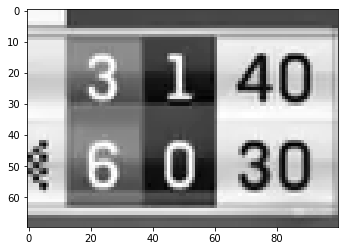

In [25]:
# 输入
plt.imshow(score,cmap = 'gray')

result = reader.readtext(score,link_threshold= 0.5,min_size=1,detail = False)
result
play1 = {}
seq = []
for num in result:
    if num != '15' or '30' or '40':
        if len(num) ==2:
            seq.append(num[0])
            seq.append(num[1])
        if len(num) == 1:
            seq.append(num)
            







In [27]:
result

['31', '40', '6 0  30']

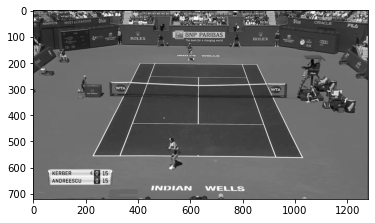

In [2]:
video_path = '/home/expend_toshiba/xieyuning/video/2019WTA印第安维尔斯站女单决赛科贝尔VS安德莱斯库 英文录播.ts'
game = TennisGame_processor(video_path,'../model/best_model.pkl')
# img = cv2.imread(r'./scoreboard2.png')
img = game.random_frame()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap = 'gray')

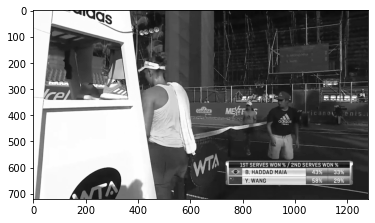

In [6]:
video_path = '/home/expend_toshiba/xieyuning/video/2019WTA阿卡普尔科站女单1_4决赛玛雅VS王雅繁 英文录播.ts'
game = TennisGame_processor(video_path,'../model/best_model.pkl')
# img = cv2.imread(r'./scoreboard2.png')
img = game.random_frame()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap = 'gray')


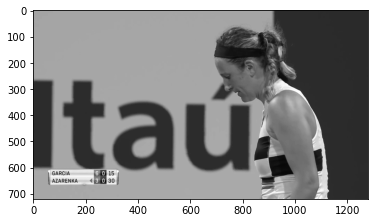

In [7]:
game = TennisGame_processor('../video/2019WTA迈阿密赛女单第2轮加西亚VS阿扎伦卡 英文录播.ts','../model/best_model.pkl')
# img = cv2.imread(r'./scoreboard2.png')
img = game.random_frame()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap = 'gray')

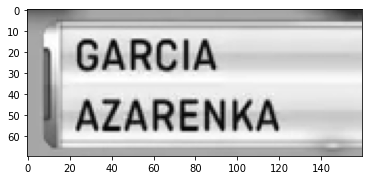

In [8]:
name = img[600:670,50:210]
score = img[600:670,220:350]
plt.imshow(name,cmap = 'gray')

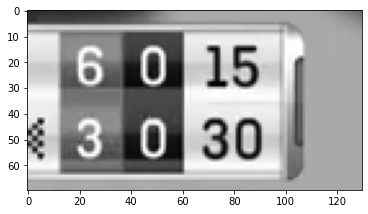

In [9]:
plt.imshow(score,cmap = 'gray')

In [11]:
result = reader.readtext(name,link_threshold= 0.1,min_size=1,detail=False)
result

['GARCIA', 'AZARENKA']

In [12]:
result = reader.readtext(score,link_threshold= 0.5,min_size=1,detail=False)
result

['60', '15', ': 30  30']

In [125]:
help(reader.readtext)

Help on method readtext in module easyocr.easyocr:

readtext(image, decoder='greedy', beamWidth=5, batch_size=1, workers=0, allowlist=None, blocklist=None, detail=1, rotation_info=None, paragraph=False, min_size=20, contrast_ths=0.1, adjust_contrast=0.5, filter_ths=0.003, text_threshold=0.7, low_text=0.4, link_threshold=0.4, canvas_size=2560, mag_ratio=1.0, slope_ths=0.1, ycenter_ths=0.5, height_ths=0.5, width_ths=0.5, add_margin=0.1) method of easyocr.easyocr.Reader instance
    Parameters:
    image: file path or numpy-array or a byte stream object



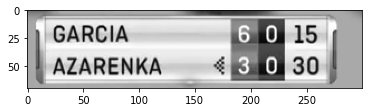

In [10]:
alll = img[600:670,50:350]
plt.imshow(alll,cmap = 'gray')